# From kernel string to structure drawing

### Task & Goal


### Steps
EXTRACT INFORMATION FROM STRING  
DETERMINE STRUCTURE  
DRAW SHAPES  

In [1]:
import re

import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

import drawSvg as draw

C:\Anaconda3\lib\site-packages\drawSvg\raster.py:18: RuntimeWarning: Failed to import CairoSVG. drawSvg will be unable to output PNG or other raster image formats. See https://github.com/cduck/drawSvg#prerequisites for more details.
Original OSError: no library called "cairo-2" was found
no library called "cairo" was found
cannot load library 'C:\GTK\bin\libcairo-2.dll': error 0xc1
cannot load library 'libcairo.so.2': error 0x7e
cannot load library 'libcairo.2.dylib': error 0x7e
cannot load library 'libcairo-2.dll': error 0xc1
  warnings.warn(msg, RuntimeWarning)


#### What is an invalid string?

Invalid characters  
Angle: [-179, 180]  
etc.

In [2]:
#error handling step 1
def check_string_valid(string):
    if re.search("[$ß€]", string): #all special characters?
        raise Exception("bad string")
        
#check_string_valid("@90 a ß90 b")

## EXTRACT INFORMATION FROM STRING

First, count domains and create a table that has nrow corresponding to dom. count. As the string is very systematic, with a regional expression I can separate the domains with all their information given.  
The good thing here is that the sequence of domains is clear from the string.  
Most important is to know which domain is paired with which. As a human, when I find a bracket in the string, I look for its counterpart. This will have to be done in the second step and put the pairing info into a dictionary(?).

In [2]:
#table(int) - cols: angle before dom, length, dom type?, if there is a strand break after  
#dictionary - pairedness  
#list of list - name of domains, their preliminary type 

def comprehend_string(string):
    #separate domains/count
    pattern = re.compile('@?-?[0-9]* ?[a-z|A-Z|0-9|\*]+[ \(]? ?\+?|\) ?\+?')
    dom_raw_list = pattern.findall(string)
    dom_count = len(dom_raw_list)
        
    #create empty data structures     
    struct_info_array = np.zeros((dom_count, 2), dtype = 'int') #3 cols rn, sb not needed here
    #empty angles indicated by -999
    for row in range(dom_count):
        struct_info_array[row, 0] = -999
    name_list1 = []
    
    #loop through the raw domains, extract  
    for dom_i in range(len(dom_raw_list)):
        dom = dom_raw_list[dom_i]
        dom = dom.strip()
        
        #fill table
        if re.search("\s", dom):
            dom_parts = re.split("\s", dom)
            
            for segm in dom_parts:
                if segm[0] is "@": #col0 angle
                    segm = segm.lstrip("@")
                    struct_info_array[dom_i, 0] = int(segm) #col0 to write to
                    #struct_info_array[dom_i, 1] = np.sign(int(segm)) #col1 to write to
                    
                #elif segm is "+": #col2 strand break
                #    struct_info_array[dom_i, 2] = 1         #col2 to write to
                elif segm is not "+": #else:
                    name_list1.append(segm) #only keep the name part further
        else:
            name_list1.append(dom)
        
    #pairedness dictionary
    paired_dict = {}
    
    for dom_i2 in range(len(dom_raw_list)):
        if re.search("\(", dom_raw_list[dom_i2]):
            bracket_count = 1
            for next_dom in range(dom_i2+1, len(dom_raw_list)):
                if re.search("\(", dom_raw_list[next_dom]):
                    bracket_count += 1
                elif re.search("\)", dom_raw_list[next_dom]):
                    bracket_count -= 1
                if bracket_count == 0:
                    paired_dict[dom_i2] = next_dom
                    break
    
    #name list of list / finding hairpin loops
    #paireds in dict, hairpin loop known, other are unpaired -> substructure from these?
    name_final_lol = []
    
    for dom_i3 in range(len(name_list1)):
        
        #paireds
        if re.search("\(", name_list1[dom_i3]):
            typ = "paired"
            name = name_list1[dom_i3].strip("(+ ")
        
        #correcting closing bracket name
        elif re.search("\)", name_list1[dom_i3]):
            typ = "paired"
            index_of_pair = list(paired_dict.keys())[list(paired_dict.values()).index(dom_i3)]
            if re.search("\*", name_list1[index_of_pair]):
                name = name_list1[index_of_pair].strip("\(").strip("\*")
            else:
                name = name_list1[index_of_pair].strip("\(") + "*"
        
        #all other are unpaireds
        else:
            typ = "unpaired"
            name = name_list1[dom_i3].strip("+ ")
        
        name_final_lol.append([name, typ])
        
    return dom_raw_list, struct_info_array, paired_dict, name_final_lol

In [27]:
string = "@-45 d1S T2 @-135 b( a( t2( + ) ) c*( t1* + ) )"
comprehend_string(string)[1:4]

(array([[ -45,    0],
        [-999,    0],
        [-135,    0],
        [-999,    0],
        [-999,    0],
        [-999,    0],
        [-999,    0],
        [-999,    0],
        [-999,    0],
        [-999,    0],
        [-999,    0]]),
 {2: 10, 3: 6, 4: 5, 7: 9},
 [['d1S', 'unpaired'],
  ['T2', 'unpaired'],
  ['b', 'paired'],
  ['a', 'paired'],
  ['t2', 'paired'],
  ['t2*', 'paired'],
  ['a*', 'paired'],
  ['c*', 'paired'],
  ['t1*', 'unpaired'],
  ['c', 'paired'],
  ['b*', 'paired']])

In [4]:
string2 = "t1( c( a( + t2* ) b*( d2 t3 + ) ) )"
comprehend_string(string2)[1:4]

(array([[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]]),
 {0: 10, 1: 9, 2: 4, 5: 8},
 [['t1', 'paired'],
  ['c', 'paired'],
  ['a', 'paired'],
  ['t2*', 'unpaired'],
  ['a*', 'paired'],
  ['b*', 'paired'],
  ['d2', 'unpaired'],
  ['t3', 'unpaired'],
  ['b', 'paired'],
  ['c*', 'paired'],
  ['t1*', 'paired']])

In [6]:
string3 = "@-90 aa( @-135 i1 @-90 da( dl ) @-135 i2 @-90 aca( acl ) @-135 vr @-135 pa( pl ) @-135 i3 ) @0 c"
comprehend_string(string3)[1:4]

(array([[ -90,   -1,    0],
        [-135,   -1,    0],
        [ -90,   -1,    0],
        [   0,    0,    0],
        [   0,    0,    0],
        [-135,   -1,    0],
        [ -90,   -1,    0],
        [   0,    0,    0],
        [   0,    0,    0],
        [-135,   -1,    0],
        [-135,   -1,    0],
        [   0,    0,    0],
        [   0,    0,    0],
        [-135,   -1,    0],
        [   0,    0,    0],
        [   0,    0,    0]]),
 {0: 14, 2: 4, 6: 8, 10: 12},
 [['aa', 'paired'],
  ['i1', 'unpaired'],
  ['da', 'paired'],
  ['dl', 'unpaired'],
  ['da*', 'paired'],
  ['i2', 'unpaired'],
  ['aca', 'paired'],
  ['acl', 'unpaired'],
  ['aca*', 'paired'],
  ['vr', 'unpaired'],
  ['pa', 'paired'],
  ['pl', 'unpaired'],
  ['pa*', 'paired'],
  ['i3', 'unpaired'],
  ['aa*', 'paired'],
  ['c', 'unpaired']])

### Distance list process and merge

In [3]:
def process_length_input(struct_info_array, length_input_dict):
    zeros_list = [0 for i in range(len(struct_info_array[:,1]))]
    
    #put into list format and append list to struct_info_array as new col
    for length in length_input_dict:
        zeros_list[length] = length_input_dict[length]
        
    zeros_list = np.array(zeros_list).reshape((len(zeros_list), 1))
    struct_info_array = np.append(struct_info_array, zeros_list, axis=1)
        
    return struct_info_array

In [6]:
string = "@-45 d1S T2 @-135 b( a( t2( + ) ) c*( t1* + ) )"
length_input_dict = {0:20, 1:40}

dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
process_length_input(struct_info_array, length_input_dict)

array([[ -45,   -1,   20],
       [   0,    0,   40],
       [-135,   -1,    0],
       [   0,    0,    0],
       [   0,    0,    0],
       [   0,    0,    0],
       [   0,    0,    0],
       [   0,    0,    0],
       [   0,    0,    0],
       [   0,    0,    0],
       [   0,    0,    0]])

## DETERMINE STRUCTURE 

### 1a. Create domain node graph
Figure out if an unpaired region is from a special type - by making a network graph of the connected domains (either connected by sequence (red edge) or by pairedness (green edge)) we can find subgraphs that correspond to special domain structures that need to be handled differently.  

In [4]:
def create_skeleton(dom_raw_list, paired_dict, name_final_lol):
    #append edges to graph
    G = nx.Graph()
    
    for dom_to_dom in range(len(name_final_lol)-1):
        if re.search("\+", dom_raw_list[dom_to_dom]) is None:
            G.add_edge(dom_to_dom, dom_to_dom+1, color='r') #domains that have a connection point are conn. with red edge
    for pair in paired_dict:
        G.add_edge(pair, paired_dict[pair], color='g') #paired domains are connected with green edge
    
    return G

In [5]:
def draw_skeleton(G):
    pos = nx.kamada_kawai_layout(G)
    colors = [G[u][v]['color'] for u,v in G.edges()]
    plt.figure(figsize=(16,9))

    nx.draw_networkx(G, pos = pos, with_label = True, node_size=600,font_size=15, edge_color=colors, 
                     node_color='y', width=2)

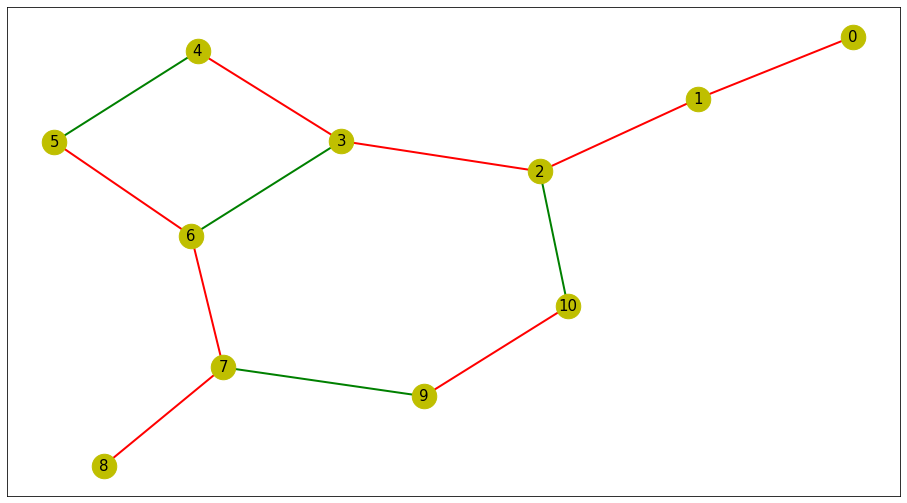

In [9]:
string = "@-45 d1S T2 @-135 b( a( t2( + ) ) c*( t1* + ) )"

dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
draw_skeleton(skeleton_graph)

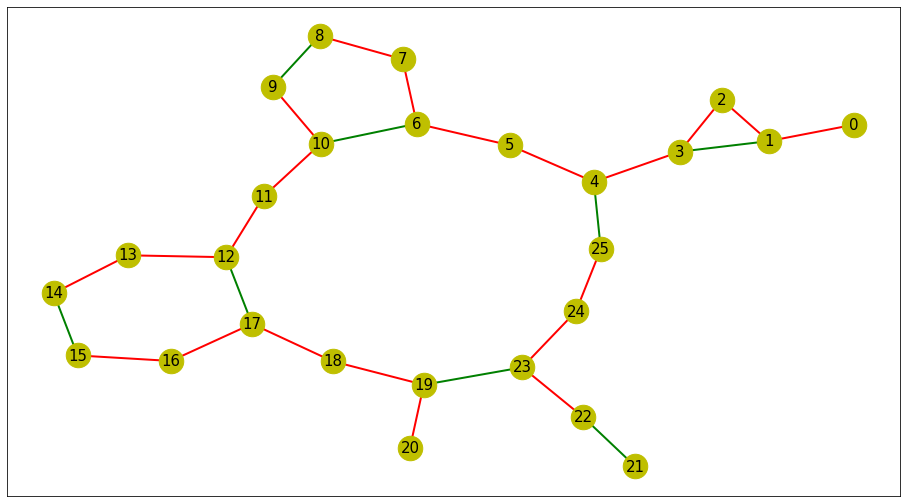

In [9]:
string = "a b( c ) d( e f( g h( + ) ) i j( k l( + ) m ) n o( p + q( + ) ) r )"
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
draw_skeleton(skeleton_graph)

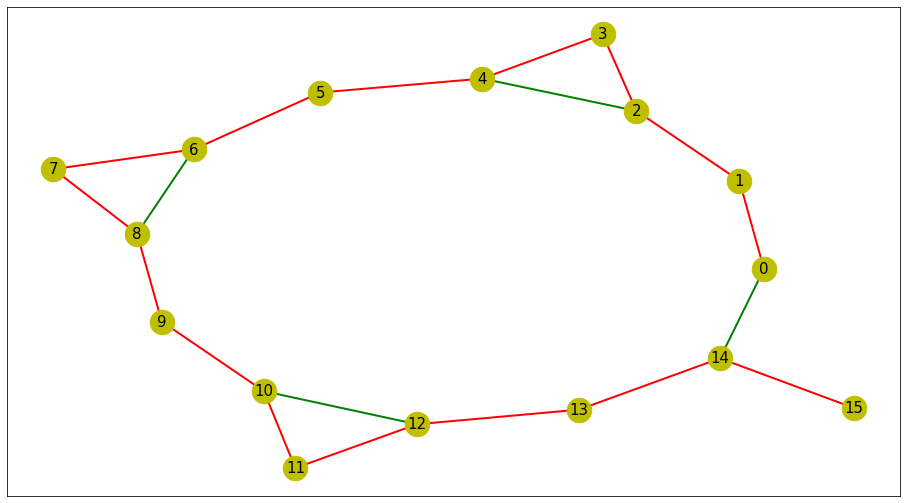

In [5]:
string = "@-90 aa( @-135 i1 @-90 da( dl ) @-135 i2 @-90 aca( acl ) @-135 vr @-135 pa( pl ) @-135 i3 ) @0 c"

dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
draw_skeleton(skeleton_graph)

### 1b. Determining unpaired domain types
Currently we check:   
hairpin loop: easy, its neighbors are paired  
unhinged: has only one neighbor domain - these will need extra care, especially ones resulting from strand break  
bulgeloop: cycles with odd nodes and only 1! unpaired dom always has the strictly taken 'bulge'  
multiloop: hard, as any number of unpaired doms can be connected with each other, only check r-g-r connection  
crossroad: if a cycle is larger or equal to 6 nodes and has no unpaired domains, it is a crossroad

nick - not tracked, but strand breaks will need much work in general

In [6]:
def ds1_find_type_of_unpaired_v2(G, paired_dict, name_final_lol):
    #index of ununpaireds - these don't need to be checked
    paired_node_list = []
    for node in paired_dict:
        paired_node_list.append(node)
        paired_node_list.append(paired_dict[node])
    
    #get unpaired too
    unpaired_node_list = []
    for node_index in range(len(name_final_lol)):
        if node_index not in paired_node_list:
            unpaired_node_list.append(node_index)
    
    #cycles of the skeleton graph
    cycle_list_G = nx.cycle_basis(G) #neat!
    multiloop_list = []
    crossroad_list = []
    
    #look through cycles, where 3cycles are hairpin, 5c. are bulge and longer ones nest multiloops
    for cycle in cycle_list_G:
        if len(cycle) == 3: #always hairpin
            for item in cycle:
                if item in unpaired_node_list:
                    name_final_lol[item][1] = "hairpin loop" #name altering
                    unpaired_node_list.remove(item) #trim unpaired list from known items
        elif len(cycle) > 3 & len(cycle) % 2 == 1: #current bulge def
            unpaired_here = []
            for item in cycle:
                if item in unpaired_node_list:
                    unpaired_here.append(item)
            if len(unpaired_here) == 1:
                name_final_lol[unpaired_here[0]][1] = "bulgeloop" #name altering
                unpaired_node_list.remove(unpaired_here[0]) #trim unpaired list from known items
         
        #find multiloops, the corresponding domains are their own list item in multiloop_list
        crossroad_tracker = True
        
        if len(cycle) >= 6:
            curr_multiloop = []
            for index in range(len(cycle)):
                if cycle[index] in unpaired_node_list:
                    crossroad_tracker = False
                    
                    if cycle[index-3] in unpaired_node_list :
                        connections = [n for n in G.edges.data(nbunch=cycle[index-1])]
                        for edge in connections:
                            #only need to check paired edge between these2
                            if edge[1] == cycle[index-2] and edge[2]['color'] is 'g': 
                                name_final_lol[cycle[index-3]][1] = "multiloop"
                                name_final_lol[cycle[index]][1] = "multiloop" #altering names
                                if cycle[index] not in curr_multiloop:
                                    curr_multiloop.append(cycle[index])
                                if cycle[index-3] not in curr_multiloop:
                                    curr_multiloop.append(cycle[index-3])
            if len(curr_multiloop) > 0:
                multiloop_list.append(curr_multiloop)
                for dom in curr_multiloop:
                    unpaired_node_list.remove(dom) #trim unpaired list from known items
            if crossroad_tracker is True: #if no unpaired region in cycle, it is a crossroad
                crossroad_list.append(cycle)
    
    #unhinged sequence
    for node_index in unpaired_node_list:
        #first neighbors
        direct_neigh = [n for n in G.neighbors(node_index)] #neighbors of current node
        
        #start from unhinged and go until all neighbors are unpaired
        if len(direct_neigh) == 1:
            name_final_lol[node_index][1] = "unhinged"
            
            next_neigh = direct_neigh
            before = [node_index]
            while len(next_neigh) == 1 and next_neigh[0] in unpaired_node_list:
                name_final_lol[next_neigh[0]][1] = "unhinged sequence"
                before.append(next_neigh[0])
                next_neigh = [n for n in G.neighbors(next_neigh[0])]
                next_neigh.remove(before[-2])
            for step in before:
                unpaired_node_list.remove(step) #bug with this line, cuts out 20 below, could implement it a bit diff
    
    #remaining is unknown but probably linear
    for remain in unpaired_node_list:
        name_final_lol[remain][1] = "ambiguous"
    
    return name_final_lol, multiloop_list, crossroad_list, cycle_list_G

In [11]:
string = "a b( c d e f ) g h i j"
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
#draw_skeleton(skeleton_graph)
ds1_find_type_of_unpaired_v2(skeleton_graph, paired_dict, name_final_lol)

([['a', 'unhinged'],
  ['b', 'paired'],
  ['c', 'multiloop'],
  ['d', 'ambiguous'],
  ['e', 'ambiguous'],
  ['f', 'multiloop'],
  ['b*', 'paired'],
  ['g', 'unhinged sequence'],
  ['h', 'unhinged sequence'],
  ['i', 'unhinged sequence'],
  ['j', 'unhinged']],
 [[2, 5]],
 [],
 [[2, 3, 4, 5, 6, 1]])

In [8]:
string = "a b( c ) d( e f( g h( + ) ) i j( k l( + ) m ) n o( p + q( + ) ) r )"
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
ds1_find_type_of_unpaired_v2(skeleton_graph, paired_dict, name_final_lol)

([['a', 'unhinged'],
  ['b', 'paired'],
  ['c', 'hairpin loop'],
  ['b*', 'paired'],
  ['d', 'paired'],
  ['e', 'multiloop'],
  ['f', 'paired'],
  ['g', 'bulgeloop'],
  ['h', 'paired'],
  ['h*', 'paired'],
  ['f*', 'paired'],
  ['i', 'multiloop'],
  ['j', 'paired'],
  ['k', 'multiloop'],
  ['l', 'paired'],
  ['l*', 'paired'],
  ['m', 'multiloop'],
  ['j*', 'paired'],
  ['n', 'multiloop'],
  ['o', 'paired'],
  ['p', 'ambiguous'],
  ['q', 'paired'],
  ['q*', 'paired'],
  ['o*', 'paired'],
  ['r', 'multiloop'],
  ['d*', 'paired']],
 [[16, 13], [5, 24, 11, 18]],
 [[2, 3, 1],
  [16, 15, 14, 13, 12, 17],
  [5, 6, 10, 11, 12, 17, 18, 19, 23, 24, 25, 4],
  [9, 8, 7, 6, 10]])

In [12]:
string = "a( b c( d( e ) f( + )) g ) h i"
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
ds1_find_type_of_unpaired_v2(skeleton_graph, paired_dict, name_final_lol)

([['a', 'paired'],
  ['b', 'multiloop'],
  ['c', 'paired'],
  ['d', 'paired'],
  ['e', 'hairpin loop'],
  ['d*', 'paired'],
  ['f', 'paired'],
  ['f*', 'paired'],
  ['c*', 'paired'],
  ['g', 'multiloop'],
  ['a*', 'paired'],
  ['h', 'unhinged sequence'],
  ['i', 'unhinged']],
 [[1, 9]],
 [[7, 6, 5, 3, 2, 8]],
 [[1, 2, 8, 9, 10, 0], [4, 5, 3], [7, 6, 5, 3, 2, 8]])

In [150]:
string = "@-45 d1S T2 @-135 b( a( t2( + ) ) c*( t1* + ) )"
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
ds1_find_type_of_unpaired_v2(skeleton_graph, paired_dict, name_final_lol)

([['d1S', 'unhinged'],
  ['T2', 'unhinged sequence'],
  ['b', 'paired'],
  ['a', 'paired'],
  ['t2', 'paired'],
  ['t2*', 'paired'],
  ['a*', 'paired'],
  ['c*', 'paired'],
  ['t1*', 'ambiguous'],
  ['c', 'paired'],
  ['b*', 'paired']],
 [],
 [[3, 6, 7, 9, 10, 2]],
 [[3, 6, 7, 9, 10, 2], [3, 4, 5, 6]])

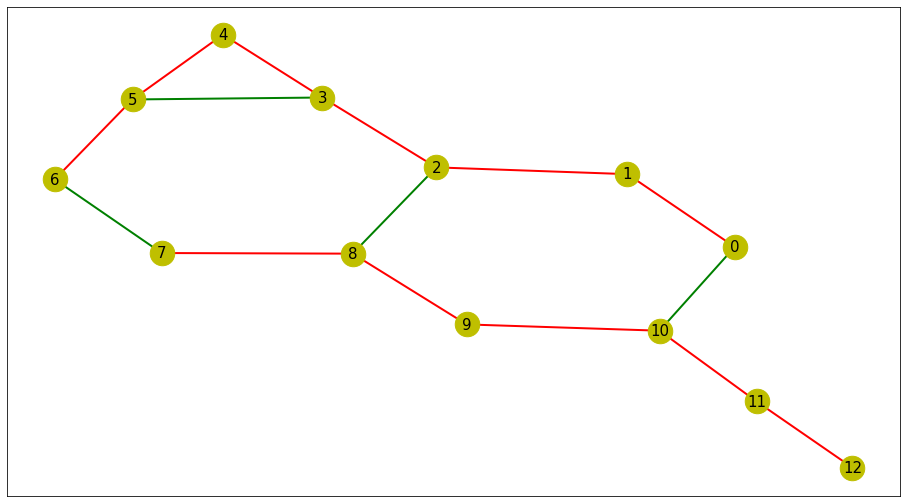

In [13]:
draw_skeleton(skeleton_graph)

### 2. Angle completion
Given angles determine the side for the substructure they are in. Using this, the whole column can be filled around the given info, if not provided, default is negative (-1) side.  
[Most problematic part]

In [7]:
def ds2_fill_side_col(struct_info_array, cycle_list_G, name_final_lol):
    dom_count = len(struct_info_array[:,1])
    
    #we take side info from sign of rel.angle, not robust solution
    for row in range(dom_count):
        if struct_info_array[row, 0] != -999:
            if name_final_lol[row][1] is "bulgeloop": #special case for bulge :/
                struct_info_array[row, 1] = np.sign(int(struct_info_array[row, 0])*-1)
            else:
                struct_info_array[row, 1] = np.sign(int(struct_info_array[row, 0]))
    
    #first loop through cycles
    for cycle in cycle_list_G:
        sides_there = []
        for dom_cyc in cycle:
            sides_there.append(struct_info_array[dom_cyc, 1])
            
        #if 1 in sides_there and -1 in sides_there:
        #    raise ValueError(f'conflicting angles with domains of index: {cycle}')   #not how should be handled
        if -1 in sides_there:
            for dom_cyc in cycle:
                struct_info_array[dom_cyc, 1] = -1
        #pos substruc
        elif 1 in sides_there:
            for dom_cyc in cycle:
                struct_info_array[dom_cyc, 1] = 1
        #neg substruc or all 0
        else:
            for dom_cyc in cycle:
                struct_info_array[dom_cyc, 1] = -1
    
    #then remaining ones are just based on previous neighbor to look more homogenous
    for dom_index in range(dom_count):
        if struct_info_array[dom_index, 1] == 0: #don't change if already given side
                if dom_index == 0:
                    struct_info_array[0, 1] = -1
                else:
                    struct_info_array[dom_index, 1] = struct_info_array[dom_index-1, 1]
        
    return struct_info_array

In [102]:
string = "@-90 a( b ) @-90 c @90 d( e ) @90 f"
length_input_dict = {}

dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
struct_info_array = process_length_input(struct_info_array, length_input_dict)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
name_final_lol, multiloop_list, crossroad_list, cycle_list_G = ds1_find_type_of_unpaired_v2(skeleton_graph, paired_dict, name_final_lol)
ds2_fill_side_col(struct_info_array, cycle_list_G, name_final_lol)

array([[ -90,   -1,    0],
       [-999,   -1,    0],
       [-999,   -1,    0],
       [ -90,   -1,    0],
       [  90,    1,    0],
       [-999,    1,    0],
       [-999,    1,    0],
       [  90,    1,    0]])

In [31]:
string = "a( b( + ) @22 c )"
length_input_dict = {}

dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
struct_info_array = process_length_input(struct_info_array, length_input_dict)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
name_final_lol, multiloop_list, crossroad_list, cycle_list_G = ds1_find_type_of_unpaired_v2(skeleton_graph, paired_dict, name_final_lol)
ds2_fill_side_col(struct_info_array, cycle_list_G, name_final_lol)

array([[-999,   -1,    0],
       [-999,   -1,    0],
       [-999,   -1,    0],
       [  22,   -1,    0],
       [-999,   -1,    0]])

In [21]:
string = "a b( @-45 c d e @45 f ) g h i j"
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
name_final_lol, multiloop_list, crossroad_list, cycle_list_G = ds1_find_type_of_unpaired_v2(skeleton_graph, paired_dict, name_final_lol)
ds2_fill_side_col(struct_info_array, cycle_list_G, name_final_lol)

array([[-999,   -1],
       [-999,   -1],
       [ -45,   -1],
       [-999,   -1],
       [-999,   -1],
       [  45,   -1],
       [-999,   -1],
       [-999,   -1],
       [-999,   -1],
       [-999,   -1],
       [-999,   -1]])

### 3. Resolves cycles by forming geometric shapes

Do this for cycles larger than 4 nodes! Because 2 paired domains will contribute as 1 edge to the shape, so a 5-node cycle from the graph (like a basic bulge) will form a triangle  
Only 2 smaller cycle examples: hairpin and paired into paired, can be considered separately.

In [ ]:
if not fully defined (case when 2 length missing):
    keep track of what is given
    fill all angles with even degrees
    fill up sides until 2 remain unknown
    if possible next to each other
    if not:
        check if they are parallel to each other
        if they are:
            change two angles so they are not anymore


    
if not fully defined (case when 1 length missing):
    need to have x variable for angles (harder)

In [17]:
a = 10
b = 10
C = 45

def deg_to_rad(deg):
    return deg*np.pi/180

c = np.sqrt(a**2 + b**2 - 2*a*b*np.cos(deg_to_rad(C)))
c

7.653668647301795

In [120]:
def resolve_domains_in_cycles(struct_info_array, paired_dict, skeleton_graph):
    """
    
    This function handles a lot of stuff, separated in inner functions. We take cycles and assume their geometry 
    with trigonometric rules and fill in the information from the string.
    """
    
    cycle_list_G = nx.cycle_basis(skeleton_graph)
    
    paired_node_list = []
    for node in paired_dict:
        paired_node_list.append(node)
        paired_node_list.append(paired_dict[node])
        
    def give_pair_of_domain(dom_index, paired_dict):
        if dom_index in paired_dict:
            return paired_dict[dom_index]
        elif dom_index in list(paired_dict.values()):
            index_of_pair = list(paired_dict.keys())[list(paired_dict.values()).index(dom_index)]
            return index_of_pair
        else:
            raise ValueError('not actually paired')
    
    def initiate_polygon_table(cycle, struct_info_array, paired_dict, paired_node_list):
        """
        
        Create table for said polygon, the angles for the polygon depend only on relative angles from the string
        """
        
        polygon_array = np.zeros((int(polygon_sides), 3), dtype='int')
        paired_dist = 10 #could be changed
        
        curr_row = 0
        for cyc_index in range(len(cycle)):
            input_ang = struct_info_array[cycle[cyc_index], 0]  #rel. angle
            side = struct_info_array[cycle[cyc_index], 1]
            
            if cycle[cyc_index] not in paired_node_list: #at the start of an unpaired there is always a PA
                polygon_array[curr_row, 0] = cycle[cyc_index]   #remember dom name to write back to
                polygon_array[curr_row, 2] = struct_info_array[cycle[cyc_index], 2]  #dom length
                    
                curr_row += 1
                
                if cycle[cyc_index-1] not in paired_node_list: #unpaired-unpaired
                    if input_ang == -999:
                        poly_ang = 0
                    else:
                        poly_ang = 180 + input_ang*side
                    polygon_array[curr_row, 1] = poly_ang
                
                else:                                          #unpaired - paired(prev)
                    if input_ang == -999:
                        poly_ang = 0
                    else:
                        poly_ang = 90 + input_ang*side
                    polygon_array[curr_row, 1] = poly_ang
            
            else:
                pair_of_curr = give_pair_of_domain(cycle[cyc_index], paired_dict)
                
                if cycle[cyc_index - 1] not in paired_node_list: #paired-unpaired
                    if input_ang == -999:
                        poly_ang = 0
                    else:
                        poly_ang = 90 + input_ang*side
                    
                    polygon_array[curr_row, 0] = cycle[cyc_index]   #remember dom name to write back to
                    polygon_array[curr_row, 1] = poly_ang
                    polygon_array[curr_row, 2] = paired_dist  #dom length
                
                    curr_row += 1 #update row in polygon_array
                    
                elif cycle[cyc_index - 1] in paired_node_list and cycle[cyc_index - 1] != pair_of_curr: #paired-paired
                    if input_ang == -999:
                        poly_ang = 0
                    else:
                        poly_ang = np.abs(input_ang)
                    
                    polygon_array[curr_row, 0] = cycle[cyc_index]   #remember dom name to write back to
                    polygon_array[curr_row, 1] = poly_ang
                    polygon_array[curr_row, 2] = paired_dist  #dom length
                
                    curr_row += 1 #update row in polygon_array
        
        return polygon_array
    
    def polygon_fully_defined(polygon_array): 
        """Return False if not enough data available for the polygon"""
        
        n_poly = len(polygon_array[:,0])
        n_given_ang = 0
        for n in list(polygon_array[:,1]):
            if n != 0:
                n_given_ang += 1
        
        n_given_len = 0
        for n in list(polygon_array[:,2]):
            if n != 0:
                n_given_len += 1
        
        if n_poly == 3:
            if n_given_ang != 3:
                if n_given_len + n_given_ang >= 3:
                    return True
                else:
                    return False
            else:
                if n_given_len != 0:
                    return True
                else:
                    return False
                
        #all other polygons - currently bad
        else:  
            if n_given_len >= n_poly-2 and n_given_ang == n_poly:
                return True #if 2 unknown and these are parallel, not fully defined
            elif n_given_len == n_poly and n_given_ang >= n_poly-2:
                return True
            else:
                return False
    
    def assume_fill_polyarr(polygon_array):
        """
        
        Fill up missing variables in an educated manner until the 'polygon' is fully defined. 
        Then hand it over to calculate missing.
        Case not implemented: if more domain length are given for a cycle than "domains in cycle" - 2.
        """
               
        n_poly = len(polygon_array[:,0])
        n_given_ang = 0
        given_ang_list = []
        angle_list = list(polygon_array[:,1])
        for n in angle_list:
            if n != 0:
                n_given_ang += 1
                given_ang_list.append()
        
        n_given_len = 0
        for n in list(polygon_array[:,2]):
            if n != 0:
                n_given_len += 1
        
        #case1
        if n_given_len <= n_poly-2:
            pass
            #fill all angles
            
            #if no lengths present, we add one
            #check definedness, add lengths one by one, repeat 
            
        #case2 - not implemented yet
        elif n_given_len == n_poly:
            pass
        
        #case3 - not implemented yet
        elif n_given_len == n_poly-1:
            pass
    
    def calculate_remaining(polygon_array):
        pass
    
    def feed_polyarr_to_structarray(struct_info_array, polygon_array, cycle, paired_node_list):
        """Write back calculated relative angles and domain lengths(if appropriate) to SIA"""
        
        for poly_index in range(len(polygon_array[:,0])):
            curr_dom_index = polygon_array[poly_index, 0]
            poly_ang = polygon_array[poly_index, 1]
            poly_len = polygon_array[poly_index, 2]
            
            side = struct_info_array[curr_dom_index, 1]
            cyc_index = cycle.index(curr_dom_index)
            
            if curr_dom_index not in paired_node_list: #at the start of an unpaired there is always a polygon angle
                struct_info_array[curr_dom_index, 2] = poly_len #if unpaired, the length we write over
                
                if cycle[cyc_index-1] not in paired_node_list: #unpaired-unpaired
                    rel_angle = (poly_ang - 180) / side
                    struct_info_array[curr_dom_index, 0] = rel_angle
                
                else:                                          #unpaired - paired(prev)
                    rel_angle = (poly_ang - 90) / side
                    struct_info_array[curr_dom_index, 0] = rel_angle
            
            else:
                if cycle[cyc_index - 1] not in paired_node_list: #paired-unpaired
                    rel_angle = (poly_ang - 90) / side
                    struct_info_array[curr_dom_index, 0] = rel_angle
                    
                else: #it is always the right paired-paired, as we only put those in the table
                    rel_angle = poly_ang*side
                    struct_info_array[curr_dom_index, 0] = rel_angle
        
        return struct_info_array
    
    #MAIN LOOP
    for cycle in cycle_list_G:
        #if all length and angles already there, we can skip the polygon part
        pass
        
        polygon_sides = 0
        for item in cycle:
            if item in paired_node_list:
                polygon_sides += 0.5
            else:
                polygon_sides += 1
                
        if polygon_sides == 2: #special cases
            if len(cycle) == 3: #hairpin, nothing to do here
                pass
            elif len(cycle) == 4: #paired into paired, can fill in two 0 angles
                cycle.sort()      #the domains will be after this always the secomd and fourth in cycle
                struct_info_array[cycle[1], 0] = 0
                struct_info_array[cycle[3], 0] = 0
                
            return struct_info_array
                
        if polygon_sides >= 3: #has a polygon
            polygon_array = initiate_polygon_table(cycle, struct_info_array, paired_dict, paired_node_list)
            print(polygon_array)
            print(polygon_fully_defined(polygon_array))
            
            if polygon_fully_defined(polygon_array) is True:
                pass
                #polygon_array = calculate_remaining(polygon_array)
            else:
                pass
                #polygon_array = assume_fill_polyarr(polygon_array)
                #polygon_array = calculate_remaining(polygon_array)     
            
            #add calculated info back to SIA
            struct_info_array2 = feed_polyarr_to_structarray(struct_info_array, polygon_array, cycle, paired_node_list)
            
            return struct_info_array2

In [36]:
string = "d1 d2 @-45 a( @-45 b( + ) c )"
length_input_dict = {0:30, 1:30}
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
struct_info_array = process_length_input(struct_info_array, length_input_dict)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
name_final_lol, multiloop_list, crossroad_list, cycle_list_G = ds1_find_type_of_unpaired_v2(skeleton_graph, paired_dict, name_final_lol)
struct_info_array = ds2_fill_side_col(struct_info_array, cycle_list_G, name_final_lol)
print(struct_info_array)
resolve_domains_in_cycles(struct_info_array, paired_dict, skeleton_graph)

[[-999   -1   30]
 [-999   -1   30]
 [ -45   -1    0]
 [ -45   -1    0]
 [-999   -1    0]
 [-999   -1    0]
 [-999   -1    0]]
[[ 3 45 10]
 [ 5  0  0]
 [ 6  0 10]]
True


array([[-999,   -1,   30],
       [-999,   -1,   30],
       [ -45,   -1,    0],
       [ -45,   -1,    0],
       [-999,   -1,    0],
       [  90,   -1,    0],
       [  90,   -1,    0]])

In [37]:
string = "a( @0 b @0 c( + ) d )"
length_input_dict = {}
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
struct_info_array = process_length_input(struct_info_array, length_input_dict)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
name_final_lol, multiloop_list, crossroad_list, cycle_list_G = ds1_find_type_of_unpaired_v2(skeleton_graph, paired_dict, name_final_lol)
struct_info_array = ds2_fill_side_col(struct_info_array, cycle_list_G, name_final_lol)
print(struct_info_array)
resolve_domains_in_cycles(struct_info_array, paired_dict, skeleton_graph)

[[-999   -1    0]
 [   0   -1    0]
 [   0   -1    0]
 [-999   -1    0]
 [-999   -1    0]
 [-999   -1    0]]
[[ 1  0  0]
 [ 2 90 10]
 [ 4  0  0]
 [ 5  0 10]]
False


### 4. Determine traversing order based on graph 

This will ensure that every domain is approached from a point that is already known

Start at the beginning, walk along the network with the following preferences:  
-If it is a paired domain, we draw its pair too (since its obvious and it gives another constraint for the structure)  
-Check if domain is in cycle(substructure), if yes, we prioritize the cycle elements and get from in-point to out-point  
-While walking along the cycle, put the neighbors not in the current cycle to the back

In [9]:
#determine order of traversal (order of domains to build up)
def ds3a_determine_contstruct_order(skeleton_graph, paired_dict):
    cycle_list_G = nx.cycle_basis(skeleton_graph)
    
    paired_node_list = []
    for node in paired_dict:
        paired_node_list.append(node)
        paired_node_list.append(paired_dict[node])
    
    def find_cycle_where_index_belongs(dom_index, cycle_list_G): #now finds largest cycle
        found = []
        for cycle in cycle_list_G:
            if dom_index in cycle and len(cycle) > len(found):
                found = cycle
        return found
    
    def resort_list_to_start_by_spec_value(dom_index, list_with_value):
        index = list_with_value.index(dom_index)
        sorted_list = []
        for i in range(len(list_with_value)):
            sorted_list.append(list_with_value[index-len(list_with_value)+i])
        return sorted_list
    
    def give_pair_of_domain(dom_index, paired_dict):
        if dom_index in paired_dict:
            return paired_dict[dom_index]
        elif dom_index in list(paired_dict.values()):
            index_of_pair = list(paired_dict.keys())[list(paired_dict.values()).index(dom_index)]
            return index_of_pair
        else:
            raise ValueError('not actually paired')
    
    #
    traverse_order = [0]
    
    for node in traverse_order:
        current_in_travord = traverse_order.index(node)
        counter = 0 #helps with insert index
        
        #pair primary
        if node in paired_node_list:
            pair_first = give_pair_of_domain(node, paired_dict) #pair first!
            if pair_first not in traverse_order:
                traverse_order.insert(current_in_travord+1, pair_first)
                counter += 1
        
        #cycle secondary
        its_cycle = find_cycle_where_index_belongs(node, cycle_list_G)
        if len(its_cycle) != 0: #if in cycle
            resorted_cycle = resort_list_to_start_by_spec_value(node, its_cycle)
            
            for item in resorted_cycle:
                if item not in traverse_order:
                    traverse_order.insert(current_in_travord+counter+1, item)
                    counter += 1
                        
        #other neighbor tertiary
        neighbors = skeleton_graph.neighbors(node)
        for neighbor in neighbors:  #other neighbor third!
            if neighbor not in traverse_order:
                traverse_order.append(neighbor)

    return traverse_order

In [10]:
string = "@-45 a( @-45 b( + ) c )"
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
ds3a_determine_contstruct_order(skeleton_graph, paired_dict)

[0, 4, 1, 2, 3]

In [11]:
string = "a( b c( d( e ) f( + )) g ) h i"
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
#name_final_lol, multiloop_list, crossroad_list, cycle_list_G = ds1_find_type_of_unpaired_v2(skeleton_graph, paired_dict, name_final_lol)
#struct_info_array = ds2_fill_side_col(struct_info_array, cycle_list_G)
ds3a_determine_contstruct_order(skeleton_graph, paired_dict)

[0, 10, 1, 2, 8, 9, 11, 3, 5, 6, 7, 12, 4]

In [21]:
string = "a b( c ) d( e f( g h( + ) ) i j( k l( + ) m ) n o( p + q( + ) ) r )"
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
print(ds3a_determine_contstruct_order(skeleton_graph, paired_dict))

[0, 1, 3, 2, 4, 25, 5, 6, 10, 11, 12, 17, 18, 19, 23, 24, 7, 8, 9, 13, 15, 14, 16, 20, 22, 21]


## Building the structure step-by-step
### 1.

Go according to traverse list:  
1 . Write over known coinciding point coords - for unpaired and first of a paired pair (not for domain 0)  
2 . Each domain is drawn with known or preferred angles/length, the preferred angles  
3 . For each domain, check if assumed parameters seem correct in the context of structure thus far, if not, try other preferred angles or any other - go back to prev domain if fails?  

#### Defaults currently
Linear domain: 30  
Between pairs: 10  
Default angle lists, for different domain pairs:  
...

In [107]:
def ds3b_stepwise_buildup(struct_info_array2, paired_dict, name_final_lol, crossroad_list, traverse_order, skeleton_graph):
    """
    
    Taking the more-or-less filled SIA, we go along the traversing/drawing order, assume lengths and angles for
    unpaired, out-of-loop domains and loop starters.
    """
    
    paired_dist = 10
    
    dom_count = len(traverse_order)
    coordinate_array = np.zeros((dom_count, 4))
    cycle_list_G = nx.cycle_basis(skeleton_graph)
    
    #add a new col for absolute angle values
    struct_info_array2 = np.append(struct_info_array2, [[0] for i in range(len(struct_info_array2[:,0]))], axis=1)
    
    #average over given lengths to get a default unpaired length
    n_given_len = 0
    sum_length = 0
    for length in struct_info_array2[:,2]:
        if length != 0:
            sum_length += length
    if n_given_len == 0:
        default_length = 30
    else:
        default_length = sum_length/n_given_len
    
    #paired list as before
    paired_node_list = []
    for node in paired_dict:
        paired_node_list.append(node)
        paired_node_list.append(paired_dict[node])
        
    def get_red_neigh(domain_index, skeleton_graph):
        connections = [n for n in skeleton_graph.edges.data(nbunch=domain_index)]
        red_neigh = []
        for edge in connections:
            if edge[2]['color'] is 'r':
                red_neigh.append(edge[1])
        return red_neigh
    
    def give_pair_of_domain(dom_index, paired_dict):
        if dom_index in paired_dict:
            return paired_dict[dom_index]
        elif dom_index in list(paired_dict.values()):
            index_of_pair = list(paired_dict.keys())[list(paired_dict.values()).index(dom_index)]
            return index_of_pair
        else:
            raise ValueError('not actually paired')
    
    def get_preferred_angle(domain_index, paired_node_list, skeleton_graph): #would be better with name_final
        neighbors = get_red_neigh(domain_index, skeleton_graph)
        if min(neighbors) == domain_index-1: #connected to prev dom
            if min(neighbors) in paired_node_list and domain_index in paired_node_list:
                pref_angle = 60
            
            elif min(neighbors) in paired_node_list and domain_index not in paired_node_list:
                pref_angle = 90
            
            elif min(neighbors) not in paired_node_list and domain_index in paired_node_list:
                pref_angle = 90
            
            elif min(neighbors) not in paired_node_list and domain_index not in paired_node_list:
                pref_angle = 0
            
            else:
                raise Exception('Impossible')
            
        else:  #not connected to prev dom, so only to next dom
            if min(neighbors) in paired_node_list and domain_index in paired_node_list:
                pref_angle = 60
            
            elif min(neighbors) in paired_node_list and domain_index not in paired_node_list:
                pref_angle = 90
            
            elif min(neighbors) not in paired_node_list and domain_index in paired_node_list:
                pref_angle = 90
            
            elif min(neighbors) not in paired_node_list and domain_index not in paired_node_list:
                pref_angle = 0
            
            else:
                raise Exception('Impossible')
        
        return pref_angle
    
    def normal_length1(vector, side):
        unit_vector = vector/np.linalg.norm(vector)
        unit_normal = np.array([-1*side*unit_vector[1], side*unit_vector[0]])
        
        return unit_normal
    
    def deg_to_rad(deg):
        return deg*np.pi/180
    
    def calc_coords_of_paired2(domain_index, struct_info_array2, coordinate_array):
        side = struct_info_array2[domain_index, 1]
        x0p, y0p, x1p, y1p = coordinate_array[give_pair_of_domain(domain_index, paired_dict)]
        pair1vec = np.array([x1p - x0p, y1p - y0p])
        
        #direction of normal_vec has to be opposite of the default normal_vec, as that points outside and this inside
        x0, y0 = np.array([x1p, y1p]) + normal_length1(pair1vec, side) * paired_dist *-1  
        x1, y1 = np.array([x0, y0]) + pair1vec * -1
        
        return x0, y0, x1, y1
    
    def calculate_other_two_coords(x, y, abs_angle, length):
        abs_angle_rad = deg_to_rad(abs_angle)
        
        next_x = x + np.cos(abs_angle_rad) * length
        next_y = y + np.sin(abs_angle_rad) * length
        
        return next_x, next_y
    
    def take_opposite_angle(angle):
        if angle > 0:
            angle -= 180
        else:
            angle += 180
        return angle
    
    def check_domain_intersection_to_prev_data():
        pass
    
    #MAIN LOOP   
    for domain_index in traverse_order:
        written_rows = traverse_order[0 : traverse_order.index(domain_index)] #rows before current in TO
        
        if domain_index == 0: #0th dom
            if struct_info_array2[0, 0] == -999:
                abs_angle = 0
            else:
                abs_angle = struct_info_array2[0, 0]
                struct_info_array2[0, 3] = abs_angle  #the absolute angle summation starts here
            
            if struct_info_array2[0, 2] == 0:
                length_here = default_length
            else:
                length_here = struct_info_array2[0, 2]
            
            x1,y1 = calculate_other_two_coords(0, 0, abs_angle, length_here)
            coordinate_array[0, 2] = x1
            coordinate_array[0, 3] = y1
            
        else: #all other doms
            if domain_index in paired_node_list and give_pair_of_domain(domain_index, paired_dict) in written_rows:
                x0, y0, x1, y1 = calc_coords_of_paired2(domain_index, struct_info_array2, coordinate_array)
                coordinate_array[domain_index, 0] = x0
                coordinate_array[domain_index, 1] = y0
                coordinate_array[domain_index, 2] = x1
                coordinate_array[domain_index, 3] = y1
                
                abs_of_pair = struct_info_array2[give_pair_of_domain(domain_index, paired_dict), 3]
                abs_here = take_opposite_angle(abs_of_pair)
                struct_info_array2[domain_index, 3] = abs_here
            
            else:
                side = struct_info_array2[domain_index, 1]
                neighbors = get_red_neigh(domain_index, skeleton_graph)
                
                #rel_angle cases
                if struct_info_array2[domain_index, 0] == -999:
                    rel_angle = side*get_preferred_angle(domain_index, paired_node_list, skeleton_graph)
                else:
                    rel_angle = struct_info_array2[domain_index, 0]
                    
                #dom length cases
                if struct_info_array2[domain_index, 2] == 0:
                    length_here = default_length
                else:
                    length_here = struct_info_array2[domain_index, 2]
                
                
                #for doms > 0 and previous dom didn't have strand break, x0, y0 is the same as x1, y1 of prev dom
                if len(neighbors) == 1:
                    if neighbors[0] < domain_index:
                        coordinate_array[domain_index, 0] = coordinate_array[domain_index-1, 2]
                        coordinate_array[domain_index, 1] = coordinate_array[domain_index-1, 3]
                        
                        abs_angle = struct_info_array2[neighbors[0], 3] + rel_angle
                        struct_info_array2[domain_index, 3] = abs_angle #fill out abs angle field

                        x0, y0 = coordinate_array[domain_index, 0], coordinate_array[domain_index, 1]
                        x1, y1 = calculate_other_two_coords(x0, y0, abs_angle, length_here)
                        coordinate_array[domain_index, 2] = x1
                        coordinate_array[domain_index, 3] = y1
                        
                        
                    elif neighbors[0] > domain_index:
                        coordinate_array[domain_index, 2] = coordinate_array[domain_index+1, 0]
                        coordinate_array[domain_index, 3] = coordinate_array[domain_index+1, 1]
                        
                        #change rel angle here
                        #rel_angle = take_opposite_angle(rel_angle)
                        
                        abs_angle = struct_info_array2[neighbors[0], 3] - rel_angle
                        struct_info_array2[domain_index, 3] = abs_angle #fill out abs angle field

                        x1, y1 = coordinate_array[domain_index, 2], coordinate_array[domain_index, 3] #other way around
                        x0, y0 = calculate_other_two_coords(x1, y1, abs_angle, length_here)
                        coordinate_array[domain_index, 0] = x0
                        coordinate_array[domain_index, 1] = y0
                        
                if len(neighbors) == 2:
                    for neigh in neighbors:
                        if neigh < domain_index:
                            if neigh in written_rows:
                                coordinate_array[domain_index, 0] = coordinate_array[domain_index-1, 2]
                                coordinate_array[domain_index, 1] = coordinate_array[domain_index-1, 3]
                            else:
                                #change rel angle here
                                #rel_angle = take_opposite_angle(rel_angle)

                                abs_angle = struct_info_array2[neighbors[0], 3] - rel_angle
                                struct_info_array2[domain_index, 3] = abs_angle #fill out abs angle field

                                x1, y1 = coordinate_array[domain_index, 2], coordinate_array[domain_index, 3]
                                x0, y0 = calculate_other_two_coords(x1, y1, abs_angle, length_here)
                                coordinate_array[domain_index, 0] = x0
                                coordinate_array[domain_index, 1] = y0


                        if neigh > domain_index:
                            if neigh in written_rows:
                                coordinate_array[domain_index, 2] = coordinate_array[domain_index+1, 0]
                                coordinate_array[domain_index, 3] = coordinate_array[domain_index+1, 1]
                            else:
                                abs_angle = struct_info_array2[neighbors[0], 3] + rel_angle
                                struct_info_array2[domain_index, 3] = abs_angle #fill out abs angle field

                                x0, y0 = coordinate_array[domain_index, 0], coordinate_array[domain_index, 1]
                                x1, y1 = calculate_other_two_coords(x0, y0, abs_angle, length_here)
                                coordinate_array[domain_index, 2] = x1
                                coordinate_array[domain_index, 3] = y1
    print(struct_info_array2)

    return coordinate_array

In [22]:
string = "a b c d e( f ) g"
length_input_dict = {}
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
struct_info_array = process_length_input(struct_info_array, length_input_dict)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
name_final_lol, multiloop_list, crossroad_list, cycle_list_G = ds1_find_type_of_unpaired_v2(skeleton_graph, paired_dict, name_final_lol)
print(name_final_lol)
struct_info_array = ds2_fill_side_col(struct_info_array, cycle_list_G, name_final_lol)
struct_info_array2 = resolve_domains_in_cycles(struct_info_array, paired_dict, skeleton_graph)
print(struct_info_array2)
traverse_order = ds3a_determine_contstruct_order(skeleton_graph, paired_dict)
print(traverse_order)
ds3b_stepwise_buildup(struct_info_array2, paired_dict, name_final_lol, crossroad_list, traverse_order, skeleton_graph)

[['a', 'unhinged'], ['b', 'unhinged sequence'], ['c', 'unhinged sequence'], ['d', 'unhinged sequence'], ['e', 'paired'], ['f', 'hairpin loop'], ['e*', 'paired'], ['g', 'ambiguous']]
[[-999   -1    0]
 [-999   -1    0]
 [-999   -1    0]
 [-999   -1    0]
 [-999   -1    0]
 [-999   -1    0]
 [-999   -1    0]
 [-999   -1    0]]
[0, 1, 2, 3, 4, 6, 5, 7]
[[-999   -1    0    0]
 [-999   -1    0    0]
 [-999   -1    0    0]
 [-999   -1    0    0]
 [-999   -1    0  -90]
 [-999   -1    0    0]
 [-999   -1    0   90]
 [-999   -1    0    0]]


array([[  0.,   0.,  30.,   0.],
       [ 30.,   0.,  60.,   0.],
       [ 60.,   0.,  90.,   0.],
       [ 90.,   0., 120.,   0.],
       [120.,   0., 120., -30.],
       [120., -30., 130., -30.],
       [130., -30., 130.,   0.],
       [130.,   0., 160.,   0.]])

[0, 4, 3, 1, 2]
[[-999   -1    0    0]
 [-999   -1    0  -90]
 [-999   -1    0    0]
 [-999   -1    0   90]
 [-999   -1    0  180]]


array([[ 0.        ,  0.        , 30.        ,  0.        ],
       [26.83772234, 19.48683298, -3.16227766,  9.48683298],
       [-3.16227766,  9.48683298,  0.        ,  0.        ],
       [ 0.        ,  0.        , 30.        , 10.        ],
       [30.        , 10.        ,  0.        , 10.        ]])

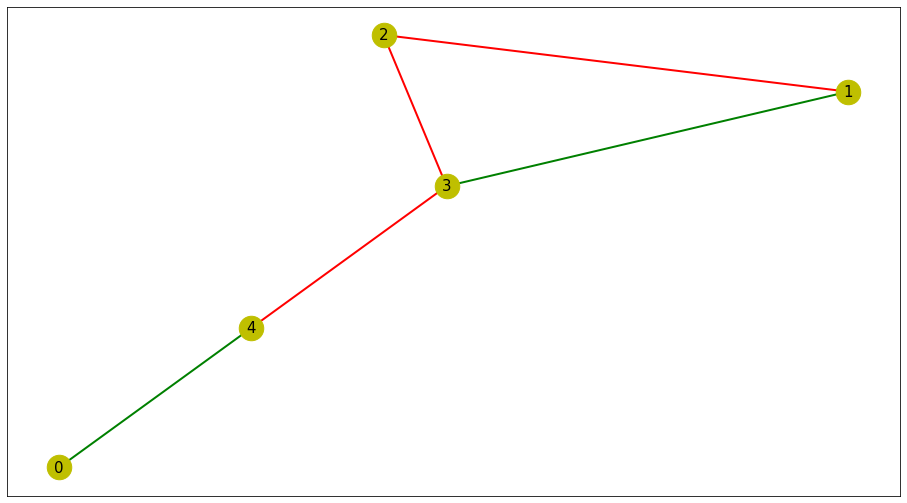

In [25]:
string = "a( + b( c ))"
length_input_dict = {}
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
struct_info_array = process_length_input(struct_info_array, length_input_dict)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
draw_skeleton(skeleton_graph)
name_final_lol, multiloop_list, crossroad_list, cycle_list_G = ds1_find_type_of_unpaired_v2(skeleton_graph, paired_dict, name_final_lol)
struct_info_array = ds2_fill_side_col(struct_info_array, cycle_list_G, name_final_lol)
struct_info_array2 = resolve_domains_in_cycles(struct_info_array, paired_dict, skeleton_graph)
traverse_order = ds3a_determine_contstruct_order(skeleton_graph, paired_dict)
print(traverse_order)
ds3b_stepwise_buildup(struct_info_array2, paired_dict, name_final_lol, crossroad_list, traverse_order, skeleton_graph)

In [ ]:
string = "a( b c( d( e ) f( + )) g ) h i"
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
name_final_lol, multiloop_list, crossroad_list, cycle_list_G = ds1_find_type_of_unpaired_v2(skeleton_graph, paired_dict, name_final_lol)
struct_info_array = ds2_fill_side_col(struct_info_array, cycle_list_G)
traverse_order = ds3a_determine_contstruct_order(skeleton_graph, paired_dict)
ds3_stepwise_buildup(struct_info_array, paired_dict, name_final_lol, crossroad_list, cycle_list_G, traverse_order)

### 2. Prepare final drawing parameters
drawing functions, names, colors, canvas size

In [145]:
#color list for each domain where: pairs are same color, multiloops are same color, 
#neighbor domains never same color

def create_color_list(name_final_lol, paired_dict, multiloop_list, palette):
    if palette is "IBM":
        colors = ["#648FFF", "#785EF0", "#DC267F", "#FE6100", "#FFB000"]
        background_cols = ["#BACCFB", "#CAC1F3", "#DC9BBB", "#F1C2A6", "#F9E5B9"] #WIP
    elif palette is "Wong":
        colors = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
        background_cols = ["#BDBDBD", "#EAC267", "#A5CCE2", "#77A79A", "#E8E4A7", "#6595B1", "#D49E73", "#C7A8BA"] #WIP
    elif palette is "Tol":
        colors = []
        background_cols = [] #WIP
    else:
        print("Palette not yet available")
        
    def give_pair_of_domain(dom_index, paired_dict):
        if dom_index in paired_dict:
            return paired_dict[dom_index]
        elif dom_index in list(paired_dict.values()):
            index_of_pair = list(paired_dict.keys())[list(paired_dict.values()).index(dom_index)]
            return index_of_pair
        else:
            raise ValueError('not actually paired')
    
    curr_color_i = 0
    for dom_index in range(len(name_final_lol)):
        color_i = curr_color_i % len(colors)
        
        if len(name_final_lol[dom_index]) == 2:
            name, domtype = name_final_lol[dom_index]

            if domtype is "paired":
                pair_index = give_pair_of_domain(dom_index, paired_dict)
                
                #index2 is line color
                name_final_lol[dom_index].append(colors[color_i])
                name_final_lol[pair_index].append(colors[color_i])
                
                #index3 is only for paired, the between pair background color
                name_final_lol[dom_index].append(background_cols[color_i])
                name_final_lol[pair_index].append(background_cols[color_i])
                
                curr_color_i += 1

            elif domtype is "multiloop":
                for loop in multiloop_list:
                    if dom_index in loop:
                        for loop_index in loop:
                            name_final_lol[loop_index].append(colors[color_i])
                            
            else:
                name_final_lol[dom_index].append(colors[color_i])
                
                curr_color_i += 1
    
    return name_final_lol

In [101]:
string = "a b c d e( f ) g"
length_input_dict = {}
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
struct_info_array = process_length_input(struct_info_array, length_input_dict)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
name_final_lol, multiloop_list, crossroad_list, cycle_list_G = ds1_find_type_of_unpaired_v2(skeleton_graph, paired_dict, name_final_lol)
struct_info_array = ds2_fill_side_col(struct_info_array, cycle_list_G, name_final_lol)
struct_info_array2 = resolve_domains_in_cycles(struct_info_array, paired_dict, skeleton_graph)
traverse_order = ds3a_determine_contstruct_order(skeleton_graph, paired_dict)
coordinate_array = ds3b_stepwise_buildup(struct_info_array2, paired_dict, name_final_lol, crossroad_list, traverse_order, skeleton_graph)

palette = "IBM"
name_final_lol = create_color_list(name_final_lol, paired_dict, multiloop_list, palette)
name_final_lol

[[-999   -1    0    0]
 [-999   -1    0    0]
 [-999   -1    0    0]
 [-999   -1    0    0]
 [-999   -1    0  -90]
 [-999   -1    0    0]
 [-999   -1    0   90]
 [-999   -1    0    0]]


[['a', 'unhinged', '#648FFF'],
 ['b', 'unhinged sequence', '#785EF0'],
 ['c', 'unhinged sequence', '#DC267F'],
 ['d', 'unhinged sequence', '#FE6100'],
 ['e', 'paired', '#FFB000', '#FBD071'],
 ['f', 'hairpin loop', '#648FFF'],
 ['e*', 'paired', '#FFB000', '#FBD071'],
 ['g', 'ambiguous', '#785EF0']]

## FINAL DRAWING
Use drawing functions

In [54]:
def lin_domain(x0, y0, x1, y1, side, name, color):
    
    def normal_length1(vector, side):
        unit_vector = vector/np.linalg.norm(vector)
        unit_normal = np.array([-1*side*unit_vector[1], side*unit_vector[0]])
        
        return unit_normal
    
    #draw line from 5' to 3'
    p = draw.Line(x0, y0, x1, y1, stroke = color)
                  
    text_col = 'black'
    offset_len = 7
    text_size = 8
    
    #label has to be on its correct side
    vector = np.array([x1 - x0, y1 - y0])
    label_offset = normal_length1(vector, side) * offset_len
    x_text, y_text = np.array([x0,y0]) + vector/2 + label_offset
        
    t = draw.Text(name, text_size, x_text, y_text, fill = color)
    
    return p, t

In [91]:
def hairpin_loop(x0, y0, x1, y1, side, name, color):
    
    offset_len = 7
    text_size = 8
    
    def normal_length1(vector, side):
        unit_vector = vector/np.linalg.norm(vector)
        unit_normal = np.array([-1*side*unit_vector[1], side*unit_vector[0]])
        
        return unit_normal
    
    #formula for calculating cosA between to vectors
    def calc_degree(vector1, vector2):
        cos_alpha = np.dot(vector1, vector2)/(np.linalg.norm(vector1)*np.linalg.norm(vector2))
        degree = np.arccos(cos_alpha)*180/np.pi
        return degree
    
    #calculate Arc arguments
    r = np.sqrt((x1-x0)**2 + (y1-y0)**2) #rn radius is the distance between paired regions, will change
    
    #vector is pointing from point 0 -> point 1
    vector = np.array([x1 - x0, y1 - y0])
    vec_len = np.linalg.norm(vector)
    unit_normal = normal_length1(vector, side)
    
    #calculate center and label anchor with r and vector
    diag = np.sqrt(r**2 - (vec_len/2)**2)
    cx, cy = np.array([x0,y0])+ vector/2 + diag*unit_normal
    x_text, y_text = np.array([x0,y0])+ vector/2 + (diag+r+offset_len)*unit_normal
       
    vec_center_0 = np.array([x0-cx,y0-cy])
    vec_center_1 = np.array([x1-cx,y1-cy])
    
    #correction for 0 angle
    if np.sign(vec_center_0[1]) == 0:
        which_side0 = 1
    else:
        which_side0 = np.sign(vec_center_0[1])
    
    if np.sign(vec_center_1[1]) == 0:
        which_side1 = 1
    else:
        which_side1 = np.sign(vec_center_1[1])    
    
    #bit unclear about start/end degrees, but works
    if side == -1:
        startdeg = calc_degree(vec_center_0, np.array([1,0]))*which_side0
        enddeg = calc_degree(vec_center_1, np.array([1,0]))*which_side1
    elif side == 1:
        enddeg = calc_degree(vec_center_0, np.array([1,0]))*which_side0
        startdeg = calc_degree(vec_center_1, np.array([1,0]))*which_side1
        
    #draw
    p = draw.Arc(cx, cy, r, startdeg, enddeg,
        stroke=color, stroke_width=0.9, fill="none") #stroke_width will be also important
    
    #LABEL - if without name, no label is added
    t = draw.Text(name, text_size, x_text, y_text, fill=color) #label
        
    return p, t

In [ ]:
def multiloop():
    pass

In [137]:
def draw_image_from_coords(coordinate_array, struct_info_array2, name_final_lol, multiloop_list, paired_dict):
    
    def get_canvas_size(coordinate_array):
        x_coords = list(coordinate_array[:,0]) + list(coordinate_array[:,2])
        y_coords = list(coordinate_array[:,1]) + list(coordinate_array[:,3])
        
        x_len = (max(x_coords) - min(x_coords)) + 50 #canvas 14 incre. larger than max range
        y_len = (max(y_coords) - min(y_coords)) + 50
        
        origo = [min(x_coords) - 14, min(y_coords) - 25] #origin 7 increment lower - which is the text_offset
        canvas = [int(x_len), int(y_len)]
        
        return canvas, origo
    
    #draw process
    SCALE_METRIC = 3     #?
    CANVAS_SIZE, ORIGIN = get_canvas_size(coordinate_array)

    #image instancing
    d = draw.Drawing(CANVAS_SIZE[0], CANVAS_SIZE[1], origin=ORIGIN, displayInline=False)
    d.setPixelScale(SCALE_METRIC)
    
    for row in range(len(coordinate_array[:,0])):
        x0 = coordinate_array[row, 0]
        y0 = coordinate_array[row, 1]
        x1 = coordinate_array[row, 2]
        y1 = coordinate_array[row, 3]
        side = struct_info_array2[row, 1]
        name = name_final_lol[row][0]
        color = name_final_lol[row][2]
        
        #endings indicated
        if row == 0:
            dom1vec = np.array([x0 - x1, y0 - y1])
            vec5prime = dom1vec/np.linalg.norm(dom1vec) * 10
            t5 = draw.Text("5'", 6, vec5prime[0], vec5prime[1], fill='black')
            d.append(t5)
        elif row == len(coordinate_array[:,0])-1:
            dom_last_vec = np.array([x1 - x0, y1 - y0])
            vec3prime = np.array([x1,y1]) + dom_last_vec/np.linalg.norm(dom_last_vec) * 7
            t3 = draw.Text("3'", 6, vec3prime[0], vec3prime[1], fill='black')
            d.append(t3)
        
        #some dom types have special functions
        if name_final_lol[row][1] == "hairpin loop":
            p, t = hairpin_loop(x0, y0, x1, y1, side, name, color)
        else:
            p, t = lin_domain(x0, y0, x1, y1, side, name, color)
        d.append(p)
        d.append(t)
        
    for pair1 in paired_dict:
        pair2 = paired_dict[pair1]
        color = name_final_lol[pair1][3]
        x0, y0, x1, y1 = coordinate_array[pair1]
        x0p, y0p, x1p, y1p = coordinate_array[pair2]
        
        r = draw.Lines(x0, y0, x1, y1,
                   x0p, y0p, x1p, y1p,
                   close = False, fill = color)
        d.append(r)

    return d

In [133]:
x0 = 20
y0 = 30
x1 = 50
y1 = 80

dom_last_vec = np.array([x1 - x0, y1 - y0])
vec3prime = np.array([x1,y1]) + dom_last_vec/np.linalg.norm(dom_last_vec)*10

vec3prime

array([55.14495755, 88.57492926])

In [74]:
def master_function(string, length_input_dict, palette):
    dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
    struct_info_array = process_length_input(struct_info_array, length_input_dict)
    skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
    name_final_lol, multiloop_list, crossroad_list, cycle_list_G = ds1_find_type_of_unpaired_v2(skeleton_graph, paired_dict, name_final_lol)
    struct_info_array = ds2_fill_side_col(struct_info_array, cycle_list_G, name_final_lol)
    
    
    #if no cycles skip cycle resolve:
    if len(cycle_list_G) == 0:
        struct_info_array2 = struct_info_array
    else:
        struct_info_array2 = resolve_domains_in_cycles(struct_info_array, paired_dict, skeleton_graph)
        
        
    traverse_order = ds3a_determine_contstruct_order(skeleton_graph, paired_dict)
    coordinate_array = ds3b_stepwise_buildup(struct_info_array2, paired_dict, name_final_lol, crossroad_list, traverse_order, skeleton_graph)    
    
    name_final_lol = create_color_list(name_final_lol, paired_dict, multiloop_list, palette)
    d = draw_image_from_coords(coordinate_array, struct_info_array2, name_final_lol, multiloop_list, paired_dict)
    
    return d

In [138]:
string = "a b @60 c d e( f ) g"
length_input_dict = {}
palette = "IBM"

d = master_function(string, length_input_dict, palette)
d

[[-999   -1    0    0]
 [-999   -1    0    0]
 [  60    1    0   60]
 [-999    1    0   60]
 [-999   -1    0  -30]
 [-999   -1    0    0]
 [-999   -1    0  150]
 [-999   -1    0   60]]


In [136]:
string = "a b @120 c d e( f ) g"
length_input_dict = {}
palette = "IBM"

d = master_function(string, length_input_dict, palette)
d

[[-999   -1    0    0]
 [-999   -1    0    0]
 [ 120    1    0  120]
 [-999    1    0  120]
 [-999   -1    0   30]
 [-999   -1    0    0]
 [-999   -1    0 -150]
 [-999   -1    0 -240]]


In [140]:
string = "@45 g1 a( b ) c @90 d( gggg ) e"
length_input_dict = {0:100}
palette = "IBM"

d = master_function(string, length_input_dict, palette)
d

[[  45    1  100   45]
 [-999   -1    0  -45]
 [-999   -1    0    0]
 [-999   -1    0  135]
 [-999   -1    0   45]
 [  90    1    0  135]
 [-999    1    0    0]
 [-999    1    0  -45]
 [-999    1    0   45]]


In [111]:
#clearly buggy

string = "a( + b( c ))"
length_input_dict = {0:100}
palette = "IBM"

d = master_function(string, length_input_dict, palette)
d

[[-999   -1  100    0]
 [-999   -1    0  -90]
 [-999   -1    0    0]
 [-999   -1    0   90]
 [-999   -1    0  180]]


In [132]:
string = "@60 a @-60 b @60 c @-60 d"
length_input_dict = {0:100}
palette = "IBM"

d = master_function(string, length_input_dict, palette)
d

[[ 60   1 100  60]
 [-60  -1   0   0]
 [ 60   1   0  60]
 [-60  -1   0   0]]


In [104]:
string = "x( r + r( + ) x*( + ) t2*( + ) )"
length_input_dict = {0:50}
palette = "IBM"

d = master_function(string, length_input_dict, palette)
d

[[-999   -1   50    0]
 [-999   -1    0  -90]
 [-999   -1    0    0]
 [-999   -1    0  180]
 [-999   -1    0   60]
 [-999   -1    0  240]
 [-999   -1    0  120]
 [-999   -1    0  300]
 [-999   -1    0  180]]


In [146]:
string = "@60 a b( hp1 ) @-60 c d( hp2 ) @-60 e f( hp3 ) @-60 g"
length_input_dict = {0:40, 1:40, 8:55}
palette = "Wong"

d = master_function(string, length_input_dict, palette)
d

[[  60    1   40   60]
 [-999   -1   40  -30]
 [-999   -1    0    0]
 [-999   -1    0  150]
 [ -60   -1    0   90]
 [-999   -1    0    0]
 [-999   -1    0    0]
 [-999   -1    0  180]
 [ -60   -1   55  120]
 [-999   -1    0   30]
 [-999   -1    0    0]
 [-999   -1    0 -150]
 [ -60   -1    0 -210]]


In [144]:
string = "@30 a( b( c ))"
length_input_dict = {0:40, 1:20}
palette = "IBM"

d = master_function(string, length_input_dict, palette)
d

[[  30    1   40   30]
 [   0    1   20   30]
 [-999    1    0    0]
 [-999    1    0 -150]
 [   0    1    0 -150]]


([['d1', 'unhinged'],
  ['a', 'paired'],
  ['b', 'paired'],
  ['b*', 'paired'],
  ['a*', 'paired'],
  ['d2', 'ambiguous']],
 [],
 [],
 [[2, 3, 4, 1]])

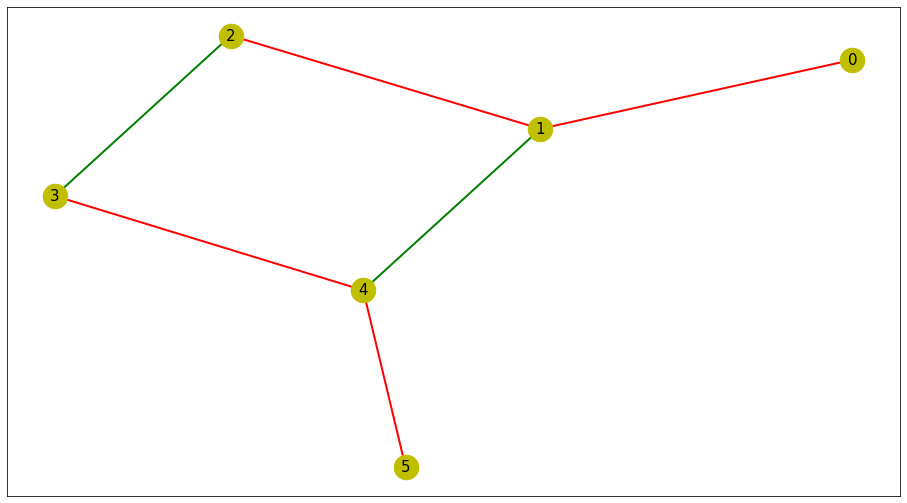

In [95]:
string = "d1 a( b( + ) ) d2"
length_input_dict = {}
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
struct_info_array = process_length_input(struct_info_array, length_input_dict)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
draw_skeleton(skeleton_graph)

ds1_find_type_of_unpaired_v2(skeleton_graph, paired_dict, name_final_lol)